In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from robustbench.utils import load_model
# Load a model from the model zoo
model = load_model(model_name='Gowal2021Improving_R18_ddpm_100m', dataset='cifar10', threat_model='Linf',  model_dir="models")


In [3]:
## get data

In [4]:
import torchvision.datasets as datasets
from torchvision import transforms
import torch
from src.utils.data_utils import create_loaders


transf = transforms.Compose([lambda x: x/1])
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

# cifar_trainset = datasets.CIFAR10(root='data', train=True, download=True, transform=None)
# cifar_testset = datasets.CIFAR10(root='data', train=False, download=True, transform=None)





batch_size = 20
n_workers = 1
data_loader = create_loaders("./data", task_config="CIFAR10",
                             batch_size=batch_size,
                             transform=transf,
                             random_state=0,
                             n_workers=n_workers)


Files already downloaded and verified


In [5]:
images, labels = next(iter(data_loader))
images, labels = images.to(device), labels.to(device)

In [6]:
from adv_lib.attacks import fmn
from tracking.tracker import PyTorchModelTrackerSetup
from logging_ import Logger
from tqdm import tqdm
import sys

logger = Logger()
tracked_model = PyTorchModelTrackerSetup(model, loss_f="CE", logger=logger)  # pytorch model


norm = float("inf")  # will use Linf norm
n_samples = 20

for b, (images, labels) in enumerate(tqdm(data_loader, total=n_samples//batch_size)):

    if b*batch_size >= n_samples:
        break

    tracked_model.setup(images, labels)
    # do attack on selected examples
    results = fmn(tracked_model, images, labels, norm, steps=10)
    tracked_model.log()
    #print(logger.loss_progress)

    #print(sum(map(lambda x: sys.getsizeof(x.storage()), logger.loss_progress)))
#     print(sys.getsizeof(logger.norm_progress.storage()))


100%|██████████| 1/1 [00:07<00:00,  7.52s/it]


In [7]:
results.shape

torch.Size([20, 3, 32, 32])

In [8]:
logger.dict.items()

dict_items([('attack', defaultdict(<function Logger.__init__.<locals>.<lambda>.<locals>.<lambda> at 0x7fede138bc10>, {'model': defaultdict(<function Logger.__init__.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda> at 0x7fedbf598d30>, {'{}': defaultdict(None, {'norm_progress': [tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.0000, 0.0401, 0.1070, 0.1092, 0.0662, 0.2201, 0.1033, 0.0627, 0.0341,
        0.0856, 0.0132, 0.1173, 0.0744, 0.1174, 0.0429, 0.0013, 0.0492, 0.0153,
        0.0625, 0.0815]), tensor([0.0000, 0.0572, 0.1642, 0.1980, 0.1197, 0.4011, 0.1814, 0.1099, 0.0488,
        0.1576, 0.0159, 0.1806, 0.1329, 0.1947, 0.0626, 0.0013, 0.0662, 0.0207,
        0.1088, 0.1445]), tensor([0.0000, 0.0577, 0.2156, 0.2483, 0.1460, 0.4852, 0.2307, 0.1449, 0.0494,
        0.1919, 0.0152, 0.2014, 0.1575, 0.2319, 0.0664, 0.0012, 0.0632, 0.0198,
        0.1243, 0.1792]), tensor([0.0000, 0.0554, 0.2531, 0.2659, 0.1488, 0.5364, 0.2459, 0.161

In [9]:
logger.norm_progress[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
[x.mean() for x in logger.loss_progress]

[tensor(0.1950),
 tensor(0.3148),
 tensor(0.5138),
 tensor(0.8096),
 tensor(1.1492),
 tensor(1.4272),
 tensor(1.6287),
 tensor(1.7635),
 tensor(1.8427),
 tensor(1.8811)]

In [11]:
results

tensor([[[[0.8667, 0.8000, 0.7843,  ..., 0.7569, 0.7608, 0.8000],
          [0.8275, 0.6863, 0.6314,  ..., 0.6157, 0.6118, 0.6863],
          [0.7765, 0.5725, 0.4667,  ..., 0.4549, 0.4471, 0.5529],
          ...,
          [0.8392, 0.7412, 0.6784,  ..., 0.8275, 0.8157, 0.8314],
          [0.8902, 0.8235, 0.7922,  ..., 0.8000, 0.8118, 0.8471],
          [0.9333, 0.8902, 0.8706,  ..., 0.8627, 0.8706, 0.9020]],

         [[0.8980, 0.8157, 0.7843,  ..., 0.7922, 0.7922, 0.8314],
          [0.8549, 0.7098, 0.6431,  ..., 0.6431, 0.6353, 0.7098],
          [0.7961, 0.5922, 0.4824,  ..., 0.4784, 0.4667, 0.5725],
          ...,
          [0.8745, 0.7529, 0.6745,  ..., 0.8314, 0.8235, 0.8471],
          [0.9255, 0.8431, 0.8039,  ..., 0.8196, 0.8314, 0.8667],
          [0.9647, 0.9137, 0.8784,  ..., 0.8824, 0.8902, 0.9216]],

         [[0.8314, 0.7569, 0.7373,  ..., 0.7137, 0.7333, 0.7765],
          [0.7882, 0.6588, 0.6078,  ..., 0.5804, 0.5961, 0.6706],
          [0.7373, 0.5490, 0.4588,  ..., 0

In [12]:
model(results).argmax(dim=-1)

tensor([4, 3, 4, 0, 0, 8, 3, 8, 9, 0, 8, 0, 6, 3, 5, 9, 3, 6, 1, 4])

In [13]:
model(images).argmax(dim=-1)

tensor([1, 1, 8, 1, 4, 9, 0, 2, 1, 7, 8, 8, 9, 7, 3, 9, 9, 9, 4, 0])

In [14]:
labels

tensor([1, 1, 8, 1, 5, 9, 0, 2, 1, 7, 8, 8, 9, 7, 3, 9, 9, 9, 4, 0])

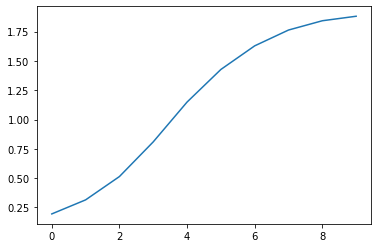

In [15]:
logger.plot_progress(kind="loss")

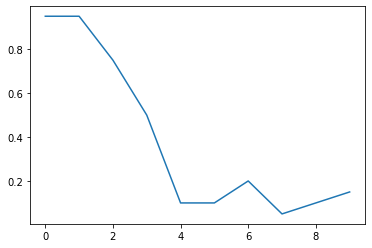

In [16]:
logger.plot_progress(kind="acc")

In [17]:
logger.acc_progress

[tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]),
 tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]),
 tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
         1., 1.]),
 tensor([0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 1.]),
 tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.])]

In [53]:
logger.save_all()

Log of attack-model-{} already saved ... skipping


In [52]:
logger.load_all(force=True)